# Analysis plan

* Load training data
* Make sure classes are evenly balanced, otherwise throw exception
* Load validation data
* Train model on training data
* Test model on validation data
* Move uncertain images from training and holdout sets to review folder
* Manually review uncertain images
* Adjust images as needed (delete bad images and move misclassified good images to training set)
* Calculate validation metrics for each occupation
* Create more training data if some occupations have bad metrics
* Repeat as needed
* Run final model against holdout data that hasn't been previously examined
* Calculate overall metrics and break out by gender and occupation
* Run final model against unlabeled data
* Save prediction for each image
* Calculate gender representation for each occupation

In [2]:
import datetime
import os
from typing import Union
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import PIL
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from IPython.display import display

if not torch.cuda.is_available():
    print("No GPU available, falling back to CPU")

In [3]:
# Config variables
train_color: str = "#ffffb3"
val_color: str = "#bebada"
unlabeled_color = "orange"
data_dir: str = 'H:/Photos/AI/'
batch_size: int = 30
classes: tuple[str, str] = ('Female', 'Male')
use_custom_normalization: bool = True
num_epochs: int = 2

In [7]:
datetime.datetime.now().strftime('%d:%H:%M:%S').replace(":", "_")

'03_09_45_59'

In [8]:
# Helpers
def current_time_only(file_safe: bool = False) -> str:
    """Print current time at second precision without date ('%H:%M:%S')."""
    if file_safe:
        datetime.datetime.now().strftime('%d:%H:%M:%S').replace(":", "_")
    else:
        return datetime.datetime.now().strftime('%H:%M:%S')


def count_files_in_directory(path: Union[str, 'LiteralString']) -> int:
    """
    Returns the number of items found in the given folder. Assumes that the path 
    contains no subdirectories and only files.

    Parameters:
    path (str): The file path to the directory whose contents are to be counted.

    Raises:
    FileNotFoundError: If the given path does not exist or is not a directory.

    Returns:
    int: The number of files in the directory.
    """
    return len(os.listdir(path))


def plot_training_progress(train_acc: list, train_loss: list, val_acc: list, val_loss: list, title="Model results"):
    """
    Plot training-vs-testing accuracy and loss for each epoch.
    
    Parameters:
        train_acc (list): List of training accuracy values from each epoch, must be same length as val_acc
        train_loss (list): List of training loss values from each epoch, must be same length as val_loss
        val_acc (list): List of validation accuracy values from each epoch, must be same length as train_acc
        val_loss (list): List of validation loss values from each epoch, must be same length as train_loss
    
    Raises:
        ValueError: If the lengths of accuracy or loss lists don't match either other
    """
    if not (len(train_acc) == len(val_acc) and len(train_loss) == len(val_loss)):
        raise ValueError("Lengths of training and validation lists must match")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_acc,
                label="Training accuracy",
                color=train_color,
                linewidth=3)
    axs[0].plot(val_acc,
                label="Validation accuracy",
                color=val_color,
                linewidth=3)
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_loss,
                label="Training loss",
                color=train_color,
                linewidth=3)
    axs[1].plot(val_loss,
                label="Validation loss",
                color=val_color,
                linewidth=3)
    axs[1].set_title("Loss")
    axs[1].set(ylim=(0, None))
    axs[1].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


# TODO: Add docstring
def label_images(csv_file: str, output_file: str):
    image_labels = []
    image_files = pl.read_csv(csv_file).to_series().to_list()

    for image_path in image_files:
        image = cv2.imread(image_path)
        if image is not None:
            cv2.putText(image, "'F'emale, 'M'ale, 'D'iscard", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow("Image", image)

            key = cv2.waitKey(0)  # Wait for a key press
            if key == ord('0') or key == ord('f'):
                image_labels.append((image_path, "Female"))
            elif key == ord('1') or key == ord('m'):
                image_labels.append((image_path, "Male"))
            elif key == ord('2') or key == ord('d'):
                image_labels.append((image_path, "Discard"))
            else:
                raise ValueError("Only allowed values are 0, 1, 2, f, m, and d")
            print(f"Key pressed: {chr(key)}")

            cv2.destroyAllWindows()
        else:
            print(f"Could not read image: {image_path}")
            image_labels.append((image_path, "ERROR"))

    with open(output_file, 'w') as f:
        for item in image_labels:
            f.write(f"{item[0]},{item[1]}\n")


class ImbalancedClassesException(ValueError):
    """Exception raised when classes must be perfectly balanced and are not."""

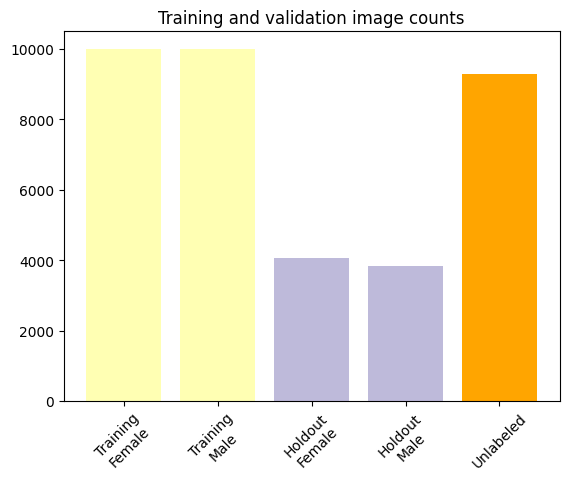

In [9]:
# Count the number of images in each training folder and throw exception if imbalanced
file_counts = {category: {gender: count_files_in_directory(
    os.path.join(data_dir, category, gender))
    for gender in classes}
    for category in ['Labeled', 'Holdout']}
file_counts.update({'Unlabeled': count_files_in_directory(os.path.join(data_dir, "Unlabeled/Unlabeled"))})

fig, ax = plt.subplots()
ax.bar(['Training\nFemale', 'Training\nMale',
        'Holdout\nFemale', 'Holdout\nMale',
        'Unlabeled'],
       [file_counts['Labeled']['Female'],
        file_counts['Labeled']['Male'],
        file_counts['Holdout']['Female'],
        file_counts['Holdout']['Male'],
        file_counts['Unlabeled']],
       color=[train_color, train_color, val_color, val_color, unlabeled_color])
plt.xticks(rotation=45)
plt.title("Training and validation image counts")
plt.show()

if file_counts['Labeled']['Female'] != file_counts['Labeled']['Male']:
    female_count = file_counts['Labeled']['Female']
    male_count = file_counts['Labeled']['Male']
    raise ImbalancedClassesException(
        f'Imbalance detected: {female_count} female images vs {male_count} male images')

In [5]:
# Calculate the mean and standard deviation of the dataset for normalization.
# These values can be used to replace the hard-coded ImageNet normalization values
# in the next code block for improved performance in certain conditions.
if use_custom_normalization:
    tensor_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to a fixed size
        transforms.ToTensor()  # Convert images to PyTorch tensors
    ])

    # Create a dataset without normalization
    unnormalized_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=tensor_transform)
    unnormalized_loader = DataLoader(unnormalized_dataset, batch_size=batch_size, shuffle=True)


    # Function to calculate mean and std
    def calculate_mean_std(loader: DataLoader) -> (torch.Tensor, torch.Tensor):
        """
        Calculate the mean and standard deviation of images in a DataLoader.
    
        Parameters:
        loader (DataLoader): The DataLoader containing the dataset.
    
        Returns:
        Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation tensors.
        """
        mean_accumulator = 0.0
        variance_accumulator = 0.0
        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean_accumulator += images.mean(2).sum(0)
            variance_accumulator += images.var(2).sum(0)

        mean_accumulator /= len(loader.dataset)
        std_deviation = torch.sqrt(variance_accumulator / len(loader.dataset))
        return mean_accumulator, std_deviation


    dataset_mean, dataset_std = calculate_mean_std(unnormalized_loader)
    normalization_values = {'mean': dataset_mean.tolist(), 'std': dataset_std.tolist()}
    del unnormalized_dataset, unnormalized_loader
    print(f"Custom normalization values: {normalization_values}")
else:
    normalization_values = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
    print("Standard normalization values used")

Custom normalization values: {'mean': [0.5009775757789612, 0.49618569016456604, 0.49482640624046326], 'std': [0.293333500623703, 0.2675815522670746, 0.2787638008594513]}


In [8]:
# Load train/test images in Pytorch format
transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Images are already 512x512 but it's good to be sure
    transforms.ToTensor(),
    transforms.Normalize(mean=normalization_values['mean'], std=normalization_values['std'])
])

train_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(os.path.join(data_dir, 'Holdout'), transform=transformations)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

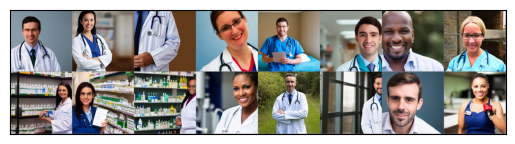

Male  Female Male  Female Male  Male  Male  Female Female Female Female Female Male  Male  Male  Female


In [9]:
def display_images_from_dataloader(dataloader: DataLoader, num_images: int = 8):
    """
    Fetches a batch of images from the given DataLoader, and displays a specified number 
    of images from this batch.

    Parameters:
    dataloader (DataLoader): A PyTorch DataLoader object from which to fetch the images.
    num_images (int): The number of images to display from the batch.
    """

    def imshow(img: torch.Tensor):
        """
        Display an image by denormalizing and clipping its values.

        This function takes a PyTorch tensor representing a grid of images, which have been normalized 
        previously, and performs denormalization to convert them back to their original color 
        space. It then clips the image values to be within the range [0, 1] to ensure 
        proper display. The image is displayed using matplotlib.

        Parameters:
        img (torch.Tensor): A PyTorch tensor representing a grid of images.
        """
        img = img.numpy().transpose((1, 2, 0))
        img = normalization_values['std'] * img + normalization_values['mean']  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    num_images = min(batch_size, num_images)
    dataset_images, dataset_labels = next(iter(dataloader))
    images_subset = dataset_images[:num_images]
    imshow(torchvision.utils.make_grid(images_subset))
    print(' '.join(f'{classes[dataset_labels[j]]:5s}' for j in range(num_images)))


display_images_from_dataloader(train_loader, num_images=16)

# ResNet model

In [10]:
# Load a pre-trained ResNet model
model_resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze the layers except the final layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for binary classification
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 2)

# Move model_resnet to GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Loss function for binary classification
criterion = nn.CrossEntropyLoss()

# Optimize the parameters of the final layer
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

In [14]:
resnet_train_epoch_loss = []
resnet_train_epoch_accuracy = []
resnet_validation_epoch_loss = []
resnet_validation_epoch_accuracy = []

# Fine-tune the ResNet model
for epoch in range(num_epochs):
    model_resnet.train()
    print(f"Epoch {epoch + 1} initiated ({current_time_only()})")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            print(f"Training batch {i + 1}/{len(train_loader)} ({current_time_only()})")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    resnet_train_epoch_loss.append(running_loss / len(train_loader))
    resnet_train_epoch_accuracy.append(correct_train / total_train)

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        print(f"Validation started ({current_time_only()})")
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store the validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct / total
    resnet_validation_epoch_loss.append(epoch_val_loss)
    resnet_validation_epoch_accuracy.append(epoch_val_accuracy)

    print("\n" + "*" * 50)
    print(f"{'*' * 10} EPOCH {epoch + 1} RESULTS {'*' * 10}".center(50))
    print("*" * 50)
    print(f'\033[94mTrain Loss: {running_loss / len(train_loader):.3f}\033[0m, '
          f'\033[92mValidation Loss: {epoch_val_loss:.3f}\033[0m, '
          f'\033[93mTraining Accuracy: {100 * correct_train / total_train:.2f}%\033[0m, '
          f'\033[91mValidation Accuracy: {100 * epoch_val_accuracy:.2f}%\033[0m')
    print("*" * 50 + "\n")

print(f'Finished Training ({current_time_only()})')

Epoch 1 initiated (19:24:01)
Training batch 1/667 (19:24:01)
Training batch 251/667 (19:33:13)
Training batch 501/667 (19:42:47)
Validation started (19:48:45)

**************************************************
       ********** EPOCH 1RESULTS **********       
**************************************************
Train Loss: 0.272, Validation Loss: 0.149, Training Accuracy: 89.36%, Validation Accuracy: 95.27%
**************************************************

Epoch 2 initiated (19:55:14)
Training batch 1/667 (19:55:14)
Training batch 251/667 (20:02:37)
Training batch 501/667 (20:09:59)
Validation started (20:14:55)

**************************************************
       ********** EPOCH 2RESULTS **********       
**************************************************
Train Loss: 0.158, Validation Loss: 0.096, Training Accuracy: 94.17%, Validation Accuracy: 96.69%
**************************************************

Epoch 3 initiated (20:20:35)
Training batch 1/667 (20:20:35)
Training batc

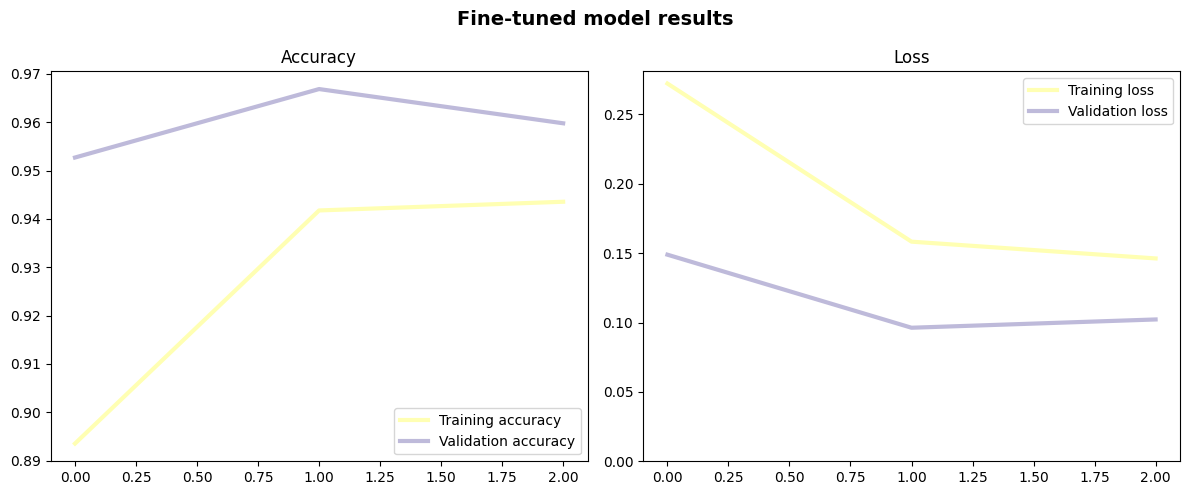

In [15]:
plot_training_progress(train_acc=resnet_train_epoch_accuracy,
                       train_loss=resnet_train_epoch_loss,
                       val_acc=resnet_validation_epoch_accuracy,
                       val_loss=resnet_validation_epoch_loss,
                       title="Fine-tuned model results")

In [16]:
def predict_model_resnet(my_dataloader):
    # TODO: Add docstring
    # TODO: Make sure batch size == 1, otherwise raise exception
    model_resnet.eval()
    prediction_results = pl.DataFrame(schema={"file_path": str, "label": int, "prediction": int, "prob_female": float})
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(my_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            prob_female = torch.nn.functional.softmax(outputs, dim=1)[:, 0].tolist()
            predicted = predicted.tolist()
            labels = labels.tolist()
            file_paths = my_dataloader.dataset.samples[i][0]
            batch_results = pl.DataFrame({"file_path": file_paths,
                                          "label": labels,
                                          "prediction": predicted,
                                          "prob_female": prob_female})
            prediction_results = pl.concat([prediction_results, batch_results], how="vertical_relaxed")
        prediction_results = prediction_results.with_columns(
            (1 * (pl.col("label") == pl.col("prediction"))).alias("correct_prediction")
        )
        # I couldn't figure out the sorting logic, so I asked SO
        # https://stackoverflow.com/questions/77700489/how-to-perform-a-conditional-sort-in-polars/77700711
        prediction_results = prediction_results.with_columns(
            abs(pl.col("prob_female") - 0.5).alias("confidence")
        ).sort([
            (good_prediction := pl.col('label').eq(pl.col('prediction'))),
            (good_prediction - 1) * pl.col('confidence'),
            pl.col('confidence')
        ])
        return prediction_results

In [17]:
exploration_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
exploration_results = predict_model_resnet(exploration_loader)

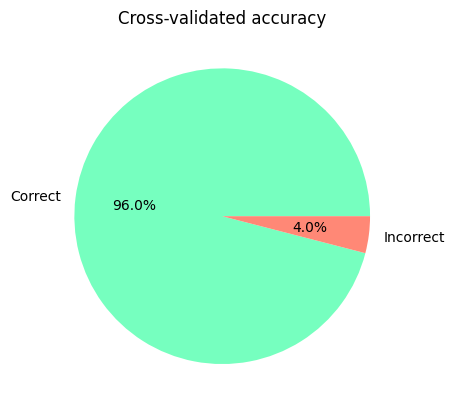

In [18]:
fig, ax = plt.subplots()
ax.pie([exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0],
        1 - exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0]],
       labels=["Correct", "Incorrect"],
       autopct="%1.1f%%",
       colors=["#76ffbf", "#ff8876"])
plt.title("Cross-validated accuracy")
plt.show()

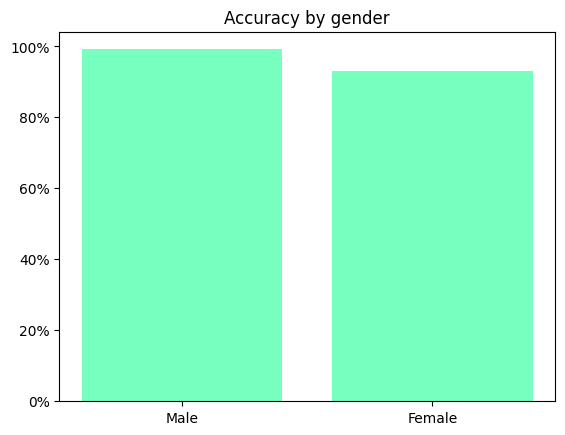

In [26]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

accuracy_by_gender = (exploration_results.select(["label", "correct_prediction"])
    .group_by("label")
    .mean()
    .with_columns(
    pl.col("label").replace(idx_to_class)
))

fig, ax = plt.subplots()
ax.bar(list(zip(*accuracy_by_gender.rows()))[0], list(zip(*accuracy_by_gender.rows()))[1], color="#76ffbf")
plt.title("Accuracy by gender")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))

plt.show()

# Next steps
* Move incorrect and low-confidence images to separate folder for review
* Retrain model as needed
* Predict gender for all unlabeled images
* Add column for occupation
* Move low-confidence predictions to review folder
* Group gender breakdowns by occupation
* Compare gender breakdowns to BLS data
* Plot scatterplot comparing breakdowns (SD vs. BLS)
* Write the paper 

In [20]:
unlabeled_dataset = ImageFolder(os.path.join(data_dir, 'Unlabeled'), transform=tensor_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

unlabeled_predictions = predict_model_resnet(unlabeled_loader)
unlabeled_predictions.drop(["label", "correct_prediction"])
unlabeled_predictions = unlabeled_predictions.with_columns(
    pl.col("file_path").str.extract("(?:[^_]*_){4}([^_]*)_").alias("occupation")
)

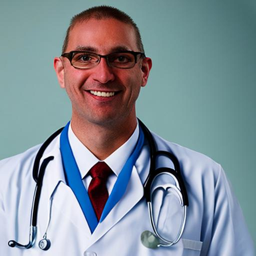

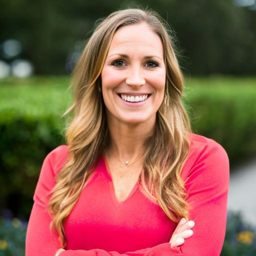

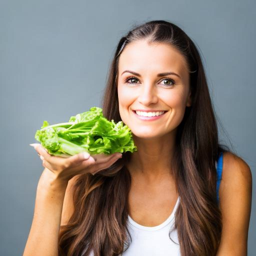

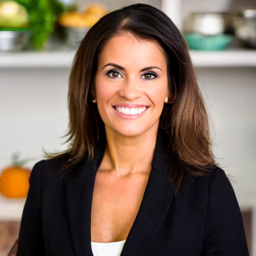

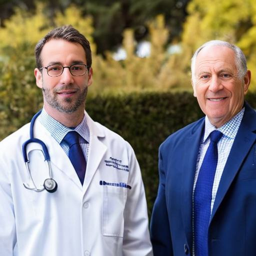

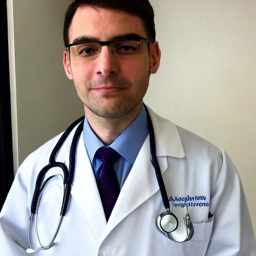

In [21]:
unlabeled_predictions.sort("confidence", descending=True).head(6).to_series(0)

for img_path in unlabeled_predictions.sort("confidence", descending=True).head(6).to_series(0):
    img = PIL.Image.open(img_path)
    display(PIL.Image.open(img_path).resize((256, 256)))


In [22]:
(unlabeled_predictions.
 select(["occupation", "prediction"]).
 group_by("occupation").
 mean().
 sort("prediction", descending=True))

occupation,prediction
str,f64
null,1.0
"""chiropractor""",0.975728
"""doctor""",0.974797
"""paramedic""",0.930362
"""dentist""",0.884462
"""pharmacist""",0.851289
"""psychologist""",0.792453
"""veterinarian""",0.612466
"""social""",0.538462


In [23]:
unlabeled_predictions.head()

file_path,label,prediction,prob_female,correct_prediction,confidence,occupation
str,i64,i64,f64,i32,f64,str
"""H:/Photos/AI/U…",0,1,0.000002,0,0.499998,"""doctor"""
"""H:/Photos/AI/U…",0,1,0.000006,0,0.499994,"""doctor"""
"""H:/Photos/AI/U…",0,1,0.000006,0,0.499994,"""doctor"""
"""H:/Photos/AI/U…",0,1,0.000008,0,0.499992,"""pharmacist"""
"""H:/Photos/AI/U…",0,1,0.000009,0,0.499991,"""doctor"""


In [27]:
# TODO: Save all low-confidence images
unlabeled_predictions.sort("confidence").head(10).select("file_path").write_csv("unlabeled_path_test.csv")

In [30]:



label_images("unlabeled_path_test.csv", "labels.csv")

Key pressed: f
Key pressed: f
Key pressed: f
Key pressed: d


ValueError: Only allowed values are 0, 1, 2, f, m, and d

In [556]:
import tkinter as tk
from tkinter import ttk
from ttkthemes import ThemedTk
from PIL import Image, ImageTk
import csv

# Constants
IMAGE_SIZE = (512, 512)
# TODO: Replace IMAGE_FILES with images for review
IMAGE_FILES = [
    "../A_photograph_of_a_veterinarian_S1633674812_St40_G7.5.jpeg",
    "../A_photograph_of_a_male_veterinarian_S1633674812_St40_G7.5.jpeg",
    "../A_portrait_of_a_veterinarian_S1345394950_St25_G7.5.525.jpeg",
    "../A_photograph_of_a_female_veterinarian_S1633674812_St40_G7.5.jpeg"
]


class ToolTip:
    def __init__(self, widget: tk.Widget):
        self.widget = widget
        self.tipwindow = None
        self.x = self.y = 0

    def show_tip(self, text: str):
        if self.tipwindow or not text:
            return
        x, y, _, _ = self.widget.bbox("insert")
        x += self.widget.winfo_rootx() + 25
        y += self.widget.winfo_rooty() + 25
        self.tipwindow = tw = tk.Toplevel(self.widget)
        tw.wm_overrideredirect(True)
        tw.wm_geometry(f"+{x}+{y}")
        label = tk.Label(tw, text=text, justify=tk.LEFT,
                         background="#ffffe0", relief=tk.SOLID, borderwidth=1,
                         font=("tahoma", "8", "normal"))
        label.pack(ipadx=1)

    def hide_tip(self):
        if self.tipwindow:
            self.tipwindow.destroy()
            self.tipwindow = None


class ImageClassifierApp:
    def __init__(self, root):
        self.root = root
        self.current_index = 0
        self.classifications = []
        self.preloaded_images = self._preload_images()
        self.setup_ui()

    def _preload_images(self):
        return [Image.open(file) for file in IMAGE_FILES]

    def setup_ui(self):
        self.image_label = ttk.Label(self.root)
        self.image_label.pack()

        self.create_buttons()
        self.create_progress_bar()
        self.create_log_window()

        self.load_next_image()

    def create_buttons(self):
        female_button = ttk.Button(self.root, text="Female", command=lambda: self.classify_image("Female"))
        female_button.pack(side=tk.LEFT)
        ToolTip(female_button).show_tip("Press 'f' for Female")

        male_button = ttk.Button(self.root, text="Male", command=lambda: self.classify_image("Male"))
        male_button.pack(side=tk.LEFT)
        ToolTip(male_button).show_tip("Press 'm' for Male")

        discard_button = ttk.Button(self.root, text="Discard", command=lambda: self.classify_image("Discard"))
        discard_button.pack(side=tk.LEFT)
        ToolTip(discard_button).show_tip("Press 'd' to Discard")

        self.root.bind('f', lambda event: self.classify_image("Female"))
        self.root.bind('m', lambda event: self.classify_image("Male"))
        self.root.bind('d', lambda event: self.classify_image("Discard"))

    def create_progress_bar(self):
        self.progress_bar = ttk.Progressbar(self.root, length=100, mode='determinate', maximum=len(IMAGE_FILES))
        self.progress_bar.pack()

    def create_log_window(self):
        self.log_window = tk.Text(self.root, height=4, width=50)
        self.log_window.pack()

    def load_next_image(self):
        if self.current_index < len(self.preloaded_images):
            img = ImageTk.PhotoImage(self.preloaded_images[self.current_index].resize(IMAGE_SIZE))
            self.image_label.configure(image=img)
            self.image_label.image = img  # Keep a reference
            self.progress_bar['value'] = self.current_index + 1
            self.current_index += 1
        else:
            self.save_to_csv()

    def classify_image(self, label: str):
        if self.current_index <= len(IMAGE_FILES):
            self.classifications.append((IMAGE_FILES[self.current_index - 1], label))
            self.log_window.insert(tk.END, f"Image {self.current_index} classified as {label}\n")
            self.log_window.see(tk.END)
            self.load_next_image()

    def save_to_csv(self):
        with open('classifications.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(self.classifications)
        print("Classifications saved to classifications.csv")
        self.root.quit()


def run_image_labeler():
    root = ThemedTk(theme="arc")
    root.title("Genderative AI Labeler")
    app = ImageClassifierApp(root)
    root.mainloop()


run_image_labeler()


Classifications saved to classifications.csv
